In [22]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import RemoveMessage
from langchain_core.runnables import RunnableConfig

In [23]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b


tools = [add, multiply, divide]
llm: ChatOpenAI = ChatOpenAI(
    base_url="http://127.0.0.1:1234/v1",
    temperature=0,
    api_key="not-needed"
)
llm_with_tools = llm.bind_tools(tools)

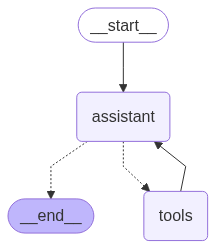

In [24]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(
    content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}


# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=MemorySaver())

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [25]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (224985380)
 Call ID: 224985380
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

<think>
Okay, the user asked to multiply 2 and 3. I see that the available functions include multiply, which takes two integers a and b. So I need to call the multiply function with a=2 and b=3. The tool call would be {"name": "multiply", "arguments": {"a": 2, "b": 3}}. Then, the result is 6, which is the correct product of 2 and 3. I should return that as the answer.
</think>

The result of multiplying 2 and 3 is 6.


## Browsing history

In [26]:
graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='d7d8db24-1289-4ee4-83c0-4e4c0a9f7f6d'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '224985380', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 164, 'prompt_tokens': 352, 'total_tokens': 516, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'qwen3-1.7b', 'system_fingerprint': 'qwen3-1.7b', 'id': 'chatcmpl-3gxxk8g85w732vvf01y74k', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--49a38467-a725-4d1b-84be-6315e4abf873-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': '224985380', 'type': 'tool_call'}], usage_metadata={'input_tokens': 352, 'output_tokens': 164, 'total_tokens': 516, 'input_token_details': {}, 'output_token_details': {}}), ToolMessage(content=

In [27]:
all_states = [s for s in graph.get_state_history(thread)]

In [28]:
len(all_states)

5

In [29]:
all_states

[StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='d7d8db24-1289-4ee4-83c0-4e4c0a9f7f6d'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '224985380', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 164, 'prompt_tokens': 352, 'total_tokens': 516, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'qwen3-1.7b', 'system_fingerprint': 'qwen3-1.7b', 'id': 'chatcmpl-3gxxk8g85w732vvf01y74k', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--49a38467-a725-4d1b-84be-6315e4abf873-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': '224985380', 'type': 'tool_call'}], usage_metadata={'input_tokens': 352, 'output_tokens': 164, 'total_tokens': 516, 'input_token_details': {}, 'output_token_details': {}}), ToolMessage(content

## Replay

In [30]:
to_replay = all_states[-2]
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='d7d8db24-1289-4ee4-83c0-4e4c0a9f7f6d')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f046ab8-a6de-6f7e-8000-e1823df0fa0d'}}, metadata={'source': 'loop', 'writes': None, 'step': 0, 'parents': {}, 'thread_id': '1'}, created_at='2025-06-11T10:05:02.429785+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f046ab8-a6dc-6865-bfff-8f1214f13601'}}, tasks=(PregelTask(id='aba96922-d81a-242f-8c19-5ae3a1ea5e47', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '224985380', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 164, 'prompt

In [31]:
to_replay.values

{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='d7d8db24-1289-4ee4-83c0-4e4c0a9f7f6d')]}

In [32]:
to_replay.next

('assistant',)

In [33]:
to_replay.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f046ab8-a6de-6f7e-8000-e1823df0fa0d'}}

In [38]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    print(event['messages'])

[HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='d7d8db24-1289-4ee4-83c0-4e4c0a9f7f6d')]
[HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='d7d8db24-1289-4ee4-83c0-4e4c0a9f7f6d'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '662234986', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 164, 'prompt_tokens': 352, 'total_tokens': 516, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'qwen3-1.7b', 'system_fingerprint': 'qwen3-1.7b', 'id': 'chatcmpl-rp1nkpj1jaqtv0hd37bng', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d65b5f92-d282-46f7-926f-ea3415ccb8b8-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': '662234986', 'type': 'tool_call'}], usage_metadata={'input_tokens': 352, 'output_tokens': 164, 'to

In [ ]:
all_states = list(graph.get_state_history(thread))
all_states

In [ ]:
to_fork = all_states[-2]
to_fork

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='d7d8db24-1289-4ee4-83c0-4e4c0a9f7f6d')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f046ab8-a6de-6f7e-8000-e1823df0fa0d'}}, metadata={'source': 'loop', 'writes': None, 'step': 0, 'parents': {}, 'thread_id': '1'}, created_at='2025-06-11T10:05:02.429785+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f046ab8-a6dc-6865-bfff-8f1214f13601'}}, tasks=(PregelTask(id='aba96922-d81a-242f-8c19-5ae3a1ea5e47', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '224985380', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 164, 'prompt

In [41]:
to_fork.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f046ab8-a6de-6f7e-8000-e1823df0fa0d'}}

In [ ]:
to_fork.values["messages"][0].id

IndexError: list index out of range

In [43]:
fork_config = graph.update_state(
    to_fork.config,
    {
        "messages": [HumanMessage(content='Multiply 5 and 3', id=to_fork.values["messages"][0].id)]
    }
)

In [44]:
fork_config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f046ad0-4c48-66ee-8001-0fb1f03c5dec'}}

We can see the current state of our agent has been updated with our fork.

In [45]:
all_states = [state for state in graph.get_state_history(thread)]
all_states[0].values["messages"]

[HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='d7d8db24-1289-4ee4-83c0-4e4c0a9f7f6d')]

In [46]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='d7d8db24-1289-4ee4-83c0-4e4c0a9f7f6d')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f046ad0-4c48-66ee-8001-0fb1f03c5dec'}}, metadata={'source': 'update', 'writes': {'__start__': {'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='d7d8db24-1289-4ee4-83c0-4e4c0a9f7f6d')]}}, 'step': 1, 'parents': {}, 'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f046ab8-a6de-6f7e-8000-e1823df0fa0d'}, created_at='2025-06-11T10:15:37.176036+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f046ab8-a6de-6f7e-8000-e1823df0fa0d'}}, tasks=(PregelTask(id='43a3fc20-3ea4-40b7-a66a-572d05bd62f3', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [47]:
for event in graph.stream(None, fork_config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 5 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (739027580)
 Call ID: 739027580
  Args:
    a: 5
    b: 3
================================= Tool Message =================================
Name: multiply

15
================================== Ai Message ==================================

<think>
Okay, the user asked to multiply 5 and 3. I need to use the multiply function. Let me check the tools provided. The multiply function takes two integers, a and b. So I'll set a to 5 and b to 3. Then, when I call the function, it should return 15. The user probably wants the result of the multiplication, so the answer is 15.
</think>

The result of multiplying 5 and 3 is 15.


In [48]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='d7d8db24-1289-4ee4-83c0-4e4c0a9f7f6d'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '739027580', 'function': {'arguments': '{"a":5,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 111, 'prompt_tokens': 352, 'total_tokens': 463, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'qwen3-1.7b', 'system_fingerprint': 'qwen3-1.7b', 'id': 'chatcmpl-yasedthk2pliyz2qhfsyot', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--be09d7d5-24b3-4970-b18c-84337d10b259-0', tool_calls=[{'name': 'multiply', 'args': {'a': 5, 'b': 3}, 'id': '739027580', 'type': 'tool_call'}], usage_metadata={'input_tokens': 352, 'output_tokens': 111, 'total_tokens': 463, 'input_token_details': {}, 'output_token_details': {}}), ToolMessage(content=